In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from scipy import stats
import xarray as xr
import xcdat as xc
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm as BM
import pandas as pd
import matplotlib as mpl
import matplotlib.ticker as mticker
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 12
# Edit axes parameters
mpl.rcParams['axes.linewidth'] = 2.0
# Tick properties
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.direction'] = 'out'

In [4]:
best_raw = xr.open_dataset('./data/tas/Berkeley_Earth_Land_and_Ocean_LatLong1.nc').temperature
best_raw['time'] = pd.date_range(start='1850-01-01', end='2023-08-31', freq='1M')
best_raw = best_raw.rename(dict(latitude = 'lat', longitude = 'lon'))
best_raw

<xarray.DataArray 'temperature' (time: 2084, lat: 180, lon: 360)>
[135043200 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2023-08-31
Attributes:
    units:          degree C
    standard_name:  surface_temperature_anomaly
    long_name:      Air Surface Temperature Anomaly
    valid_min:      -20.04033518494098
    valid_max:      25.705094288820604

In [5]:
#use population data as mask
pop_2020 = xc.open_dataset('./data/population/gpw_gridded_population_2020.nc', lon_orient=(-180, 180)).Band1
pop_2020

2024-04-08 14:01:21,589 [WARNING]: dataset.py(open_dataset:109) >> "No time coordinates were found in this dataset to decode. If time coordinates were expected to exist, make sure they are detectable by setting the CF 'axis' or 'standard_name' attribute (e.g., ds['time'].attrs['axis'] = 'T' or ds['time'].attrs['standard_name'] = 'time'). Afterwards, try decoding again with `xcdat.decode_time`."


<xarray.DataArray 'Band1' (lat: 180, lon: 360)>
[64800 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:           GDAL Band Number 1
    RepresentationType:  ATHEMATIC
    grid_mapping:        crs

In [6]:
best_raw['lat'] = pop_2020.lat
best_raw['lon'] = pop_2020.lon

In [7]:
from functions import preprocess_temp, trend_analysis, accl_analysis

## 1d implementation

In [10]:
best_gmst = preprocess_temp.calc_gmst(best_raw)
best_smooth_gmst = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(best_gmst), year = best_gmst['year'].to_numpy())).set_index('year').to_xarray().temp_smooth

best_gmst_land = preprocess_temp.calc_gmst(best_raw.where(~pop_2020.isnull()))
best_smooth_gmst_land = pd.DataFrame(data = dict(temp_smooth = preprocess_temp.loess1d(best_gmst_land), year = best_gmst_land['year'].to_numpy())).set_index('year').to_xarray().temp_smooth

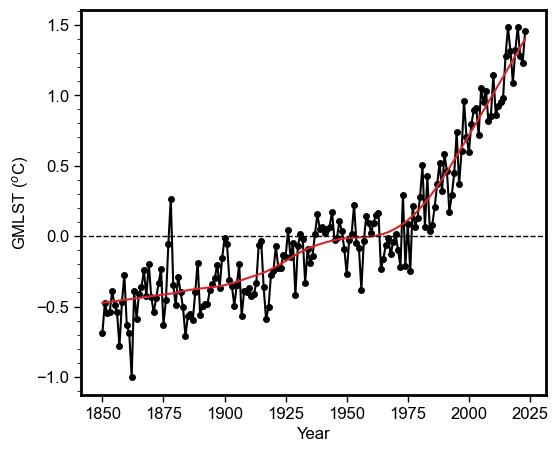

In [24]:
from turtle import color


fig = plt.figure(figsize=(6,5))
best_gmst_land.plot(marker='o', color='k', markersize=4, label='Annual Temperature')
best_smooth_gmst_land.plot(color='tab:red', label = 'Loess smooth')
plt.ylabel('GMLST ($^{o}$C)')
plt.xlabel('Year')
plt.minorticks_on()
plt.tick_params(which='minor', axis='x', bottom=False)
plt.axhline(0.0, ls='--', color='k', lw=1.0)
plt.savefig('./images/misc/gmlst.png', dpi=300, bbox_inches='tight')

In [32]:
res = accl_analysis.calc_accl(best_smooth_gmst_land, duration=100, gap=4)
res['trend'], res['ey']

(array(['increasing', 'increasing', 'increasing', 'increasing',
        'increasing', 'increasing', 'increasing', 'increasing',
        'increasing', 'increasing', 'increasing', 'increasing',
        'increasing', 'increasing', 'increasing', 'increasing',
        'increasing', 'increasing', 'increasing'], dtype='<U10'),
 array([1950, 1954, 1958, 1962, 1966, 1970, 1974, 1978, 1982, 1986, 1990,
        1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]))

1.9647711600580013e-07


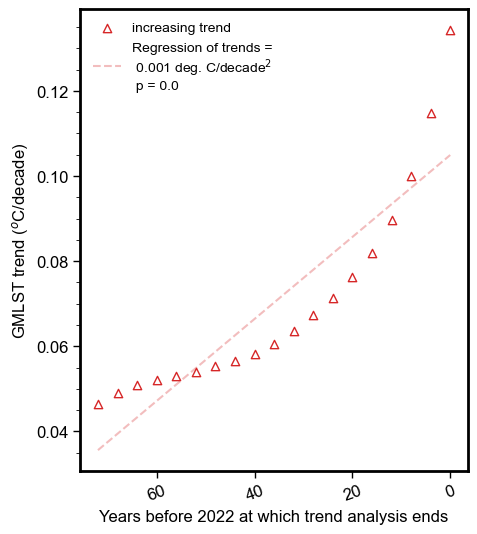

In [33]:
plt.figure(figsize=(5,6))
plt.scatter(res['distance'][:], res['slope'][:], color='tab:red', facecolor='white', marker='^', label = 'increasing trend')
# plt.scatter(res['distance'][2:8], res['slope'][2:8], color='tab:blue', facecolor='white', marker='v', label = 'decreasing trend')
# plt.scatter(res['distance'][0:3], res['slope'][0:3], color='k', facecolor='white', marker='o', label = 'no trend')
# plt.scatter(res['distance'][8:11], res['slope'][8:11], color='k', facecolor='white', marker='o', label = 'no trend')
# plt.scatter(res70['distance'], res70['slope'], color='k', facecolor='white', marker='o')
# plt.gca().set_xticklabels(['', '1850-1950', '1860-1960', '1870-1970', '1880-1980', '1890-1990', '1900-2000', '1910-2010', '1920-2020'])
plt.ylabel('GMLST trend ($^{o}$C/decade)')
plt.xlabel('Years before 2022 at which trend analysis ends')
plt.xticks(rotation=20)
plt.gca().invert_xaxis()
res1 = stats.linregress(res['distance'], res['slope'])
# res1 = stats.linregress(res70['distance'], res70['slope'])
print(res1.pvalue)
xfit = np.array(res['distance'])
# xfit = np.array(res70['distance'])
yfit = xfit*res1.slope + res1.intercept
plt.plot(xfit, yfit, ls = '--', color='tab:red', alpha = 0.3, label = f'Regression of trends = \n {-np.round(res1.slope, 4)} deg. C/decade$^2$ \n p = {np.round(res1.pvalue, 3)}')
plt.legend(frameon = False, fontsize=10)
plt.minorticks_on()
plt.gca().tick_params(which='minor', axis='x', bottom=False)

plt.savefig('./images/accl/accl_gmst100_land.png', dpi = 300, bbox_inches='tight')

## 3d implementation

In [ ]:
best_smooth = xr.open_dataset('./data/results/best_smooth_temp.nc').temperature
best_smooth

<xarray.DataArray 'temperature' (lat: 180, lon: 360, year: 174)>
[11275200 values with dtype=float64]
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2019 2020 2021 2022 2023

In [8]:
best_accl_100 = accl_analysis.calc_accl3d(best_smooth, 'year')

In [ ]:
best_pval_100 = accl_analysis.calc_pval3d(best_smooth, 'year')

In [9]:
best_accl_100.name = 'acccl'
best_pval_100.name = 'pval'
out_acccl = xr.merge([best_accl_100, best_pval_100])
out_acccl.to_netcdf('./data/results/accl/best100.nc')

## other time windows using BEST

In [7]:
best_accl_30 = accl_analysis.calc_accl3d(best_smooth, 'year', duration=32, gap=4)

In [8]:
best_pval_30 = accl_analysis.calc_pval3d(best_smooth, 'year', duration=32, gap=4)

In [9]:
best_accl_30.name = 'acccl'
best_pval_30.name = 'pval'
out_acccl = xr.merge([best_accl_30, best_pval_30])
out_acccl.to_netcdf('./data/results/accl/best30.nc')

## other datasets (lower res)

In [6]:
# load data and smoothen
noaa5deg = xr.open_dataset('./data/tas/NOAAGlobalTemp_v5.1.0_gridded_s185001_e202308_c20230908T112802.nc')
# best5deg['time'] = pd.date_range(start='1850-01-01', end='2023-09-01', freq='1M')
noaa5deg

<xarray.Dataset>
Dimensions:  (time: 2084, lat: 36, lon: 72, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2023-08-01
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
Data variables:
    anom     (time, z, lat, lon) float32 ...
Attributes: (12/66)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           NOAA Merged Land Ocean Global Surface Te...
    summary:                         NOAAGlobalTemp is a merged land-ocean su...
    institution:                     DOC/NOAA/NESDIS/National Centers for Env...
    id:                               gov.noaa.ncdc:C00934 
    naming_authority:                 gov.noaa.ncei 
    ...                              ...
    time_coverage_duration:          P173Y8M
    references:                      Vose, R. S., et al., 2012: NOAAs merged ...
    climatology:                     Climatology is based on 1971-2000 monthl...
    acknowledgment:                  The NOAA Global Surface Temperature Data...
    date_modified:                   2023-09-08T15:28:03Z
    date_issued:                     2023-09-08T15:28:03Z

In [7]:
noaa5deg_smooth = preprocess_temp.loess3d(noaa5deg.anom.ffill('time').bfill('time').groupby('time.year').mean('time'), dim='year')
noaa5deg_smooth

<xarray.DataArray 'anom' (z: 1, lat: 36, lon: 72, year: 174)>
array([[[[-1.91905100e-01, -1.91897857e-01, -1.91896772e-01, ...,
          -1.86268387e-02, -1.86065837e-02, -1.85821277e-02],
         [-1.70517524e-01, -1.71548792e-01, -1.72566582e-01, ...,
           3.00443509e-01,  3.10800765e-01,  3.21166377e-01],
         [-1.68533338e-01, -1.69665943e-01, -1.70782662e-01, ...,
           3.10857307e-01,  3.21538107e-01,  3.32227552e-01],
         ...,
         [-1.76586239e-01, -1.77345120e-01, -1.78096100e-01, ...,
           3.01844765e-01,  3.12638893e-01,  3.23455071e-01],
         [-1.73918224e-01, -1.74690150e-01, -1.75456478e-01, ...,
           3.24214682e-01,  3.35615084e-01,  3.47035586e-01],
         [-1.69008693e-01, -1.69936840e-01, -1.70858820e-01, ...,
           3.51638932e-01,  3.64129397e-01,  3.76626881e-01]],

        [[-2.84103663e-01, -2.84956529e-01, -2.85803258e-01, ...,
           2.57788043e-01,  2.66484103e-01,  2.75183707e-01],
         [-2.81620582e-01, -2.82631267e-01, -2.83631364e-01, ...,
           1.59993468e-01,  1.67451166e-01,  1.75037164e-01],
         [-2.76240096e-01, -2.77519194e-01, -2.78781943e-01, ...,
           2.21929306e-01,  2.31395369e-01,  2.40998974e-01],
...
         [-3.36238000e-01, -3.32659229e-01, -3.28976531e-01, ...,
           2.67197911e+00,  2.78415118e+00,  2.89690437e+00],
         [-3.33566446e-01, -3.30925005e-01, -3.28178394e-01, ...,
           2.59141573e+00,  2.70813010e+00,  2.82548727e+00],
         [-3.40114306e-01, -3.37931660e-01, -3.35648896e-01, ...,
           2.69412430e+00,  2.81567538e+00,  2.93791352e+00]],

        [[-4.99175941e-01, -4.89150582e-01, -4.79064709e-01, ...,
           2.82340377e+00,  2.93919310e+00,  3.05559467e+00],
         [-2.91747388e-01, -2.90374229e-01, -2.88918759e-01, ...,
           2.89612083e+00,  3.04111534e+00,  3.18686512e+00],
         [-2.70719242e-01, -2.70355983e-01, -2.69919581e-01, ...,
           2.94885492e+00,  3.09504903e+00,  3.24199299e+00],
         ...,
         [-2.04969868e-01, -2.02421569e-01, -1.99799925e-01, ...,
           2.71476173e+00,  2.86765741e+00,  3.02143460e+00],
         [-2.09674809e-01, -2.07620866e-01, -2.05486105e-01, ...,
           2.72886352e+00,  2.88414570e+00,  3.04034143e+00],
         [-2.19739538e-01, -2.17855672e-01, -2.15886680e-01, ...,
           2.69804878e+00,  2.85346438e+00,  3.00978999e+00]]]])
Coordinates:
  * lat      (lat) float32 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lon      (lon) float32 2.5 7.5 12.5 17.5 22.5 ... 342.5 347.5 352.5 357.5
  * z        (z) float32 0.0
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2019 2020 2021 2022 2023

In [72]:
noaa5deg_accl_30 = accl_analysis.calc_accl3d(noaa5deg_smooth, 'year', duration=32, gap=4)
noaa5deg_pval_30 = accl_analysis.calc_pval3d(noaa5deg_smooth, 'year', duration=32, gap=4)

In [73]:
noaa5deg_accl_30.name = 'acccl'
noaa5deg_pval_30.name = 'pval'
out_acccl = xr.merge([noaa5deg_accl_30, noaa5deg_pval_30])
out_acccl.to_netcdf('./data/results/accl/noaa5deg_30.nc')

#### ALternate dataset at 2deg - GISTEMP v4

In [8]:
gistemp = xr.open_dataset('./data/tas/gistemp1200_GHCNv4_ERSSTv5.nc')
gistemp

<xarray.Dataset>
Dimensions:      (lat: 90, lon: 180, time: 1728, nv: 2)
Coordinates:
  * lat          (lat) float32 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon          (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * time         (time) datetime64[ns] 1880-01-15 1880-02-15 ... 2023-12-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] ...
    tempanomaly  (time, lat, lon) float32 ...
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2024-01-10 11:49:05 by SBBX_to_nc 2.0 - ILAND=1200,...

In [9]:
gistemp_smooth = preprocess_temp.loess3d(gistemp.tempanomaly.ffill('time').bfill('time').groupby('time.year').mean('time'), dim='year')
gistemp_smooth

<xarray.DataArray 'tempanomaly' (lat: 90, lon: 180, year: 144)>
array([[[ 2.05644271,  2.05352196,  2.05058626, ...,  0.33285351,
          0.34539765,  0.35792228],
        [ 2.05644271,  2.05352196,  2.05058626, ...,  0.33285351,
          0.34539765,  0.35792228],
        [ 2.05644271,  2.05352196,  2.05058626, ...,  0.33285351,
          0.34539765,  0.35792228],
        ...,
        [ 2.05644271,  2.05352196,  2.05058626, ...,  0.33285351,
          0.34539765,  0.35792228],
        [ 2.05644271,  2.05352196,  2.05058626, ...,  0.33285351,
          0.34539765,  0.35792228],
        [ 2.05644271,  2.05352196,  2.05058626, ...,  0.33285351,
          0.34539765,  0.35792228]],

       [[ 2.05644271,  2.05352196,  2.05058626, ...,  0.33285351,
          0.34539765,  0.35792228],
        [ 2.05644271,  2.05352196,  2.05058626, ...,  0.33285351,
          0.34539765,  0.35792228],
        [ 2.05644271,  2.05352196,  2.05058626, ...,  0.33285351,
          0.34539765,  0.35792228],
...
        [-2.26633533, -2.27245751, -2.27848658, ...,  3.39475906,
          3.49499959,  3.59545478],
        [-2.26633533, -2.27245751, -2.27848658, ...,  3.39475906,
          3.49499959,  3.59545478],
        [-2.26633533, -2.27245751, -2.27848658, ...,  3.39475906,
          3.49499959,  3.59545478]],

       [[-2.26633533, -2.27245751, -2.27848658, ...,  3.39475906,
          3.49499959,  3.59545478],
        [-2.26633533, -2.27245751, -2.27848658, ...,  3.39475906,
          3.49499959,  3.59545478],
        [-2.26633533, -2.27245751, -2.27848658, ...,  3.39475906,
          3.49499959,  3.59545478],
        ...,
        [-2.26633533, -2.27245751, -2.27848658, ...,  3.39475906,
          3.49499959,  3.59545478],
        [-2.26633533, -2.27245751, -2.27848658, ...,  3.39475906,
          3.49499959,  3.59545478],
        [-2.26633533, -2.27245751, -2.27848658, ...,  3.39475906,
          3.49499959,  3.59545478]]])
Coordinates:
  * lat      (lat) float32 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
  * year     (year) int64 1880 1881 1882 1883 1884 ... 2019 2020 2021 2022 2023

In [14]:
gistemp_accl_30 = accl_analysis.calc_accl3d(gistemp_smooth, 'year', duration=32, gap=4)
gistemp_pval_30 = accl_analysis.calc_pval3d(gistemp_smooth, 'year', duration=32, gap=4)

In [13]:
gistemp_accl_30.name = 'acccl'
gistemp_pval_30.name = 'pval'
out_acccl = xr.merge([gistemp_accl_30, gistemp_pval_30])
out_acccl.to_netcdf('./data/results/accl/gistemp_30.nc')

## plotting the accleration figures

In [8]:
best100 = xr.open_dataset('./data/results/accl/best100.nc')
best70 = xr.open_dataset('./data/results/accl/best70.nc')
best50 = xr.open_dataset('./data/results/accl/best50.nc')
best30 = xr.open_dataset('./data/results/accl/best30.nc')

best5deg100 = xr.open_dataset('./data/results/accl/best5deg_100.nc')
best5deg70 = xr.open_dataset('./data/results/accl/best5deg_70.nc')
best5deg50 = xr.open_dataset('./data/results/accl/best5deg_50.nc')
best5deg30 = xr.open_dataset('./data/results/accl/best5deg_30.nc')

hadcrut5deg100 = xr.open_dataset('./data/results/accl/hadcrut5deg_100.nc')
hadcrut5deg70 = xr.open_dataset('./data/results/accl/hadcrut5deg_70.nc')
hadcrut5deg50 = xr.open_dataset('./data/results/accl/hadcrut5deg_50.nc')
hadcrut5deg30 = xr.open_dataset('./data/results/accl/hadcrut5deg_30.nc')

noaa5deg100 = xr.open_dataset('./data/results/accl/noaa5deg_100.nc')
noaa5deg70 = xr.open_dataset('./data/results/accl/noaa5deg_70.nc')
noaa5deg50 = xr.open_dataset('./data/results/accl/noaa5deg_50.nc')
noaa5deg30 = xr.open_dataset('./data/results/accl/noaa5deg_30.nc')

gistemp100 = xr.open_dataset('./data/results/accl/gistemp_100.nc')
gistemp70 = xr.open_dataset('./data/results/accl/gistemp_70.nc')
gistemp50 = xr.open_dataset('./data/results/accl/gistemp_50.nc')
gistemp30 = xr.open_dataset('./data/results/accl/gistemp_30.nc')

In [9]:
# loading pop data to mask for land only plots
pop_2020 = xc.open_dataset('./data/population/gpw_gridded_population_2020.nc', lon_orient=(-180, 180)).Band1
pop_2020

2024-04-08 14:01:35,580 [WARNING]: dataset.py(open_dataset:109) >> "No time coordinates were found in this dataset to decode. If time coordinates were expected to exist, make sure they are detectable by setting the CF 'axis' or 'standard_name' attribute (e.g., ds['time'].attrs['axis'] = 'T' or ds['time'].attrs['standard_name'] = 'time'). Afterwards, try decoding again with `xcdat.decode_time`."


<xarray.DataArray 'Band1' (lat: 180, lon: 360)>
[64800 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes:
    long_name:           GDAL Band Number 1
    RepresentationType:  ATHEMATIC
    grid_mapping:        crs

In [10]:
x, y = np.meshgrid(best100.lon, best100.lat)
xl1, yl1 = np.meshgrid(gistemp100.lon, gistemp100.lat)
xl2, yl2 = np.meshgrid(best5deg100.lon, best5deg100.lat)

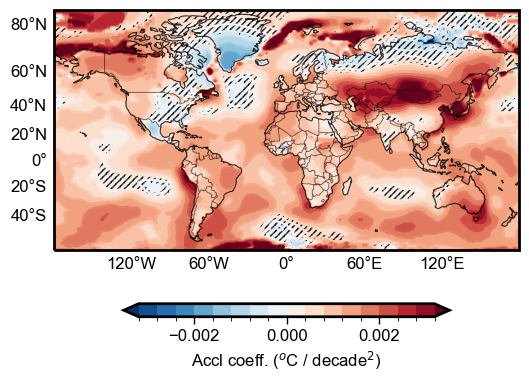

In [13]:
plt.figure(figsize=(6,7))
ax = plt.axes(projection=ccrs.Miller())
lvls = np.arange(-0.0032, 0.0036, 0.0004)
ax.set_extent([-180, 180, -60, 85])
# best100.acccl.plot(cmap='RdBu_r', vmin=-0.0032, extend='both', transform=ccrs.PlateCarree(), cbar_kwargs=dict(orientation='horizontal', shrink=0.7, pad=0.10, label = 'Accl coeff. ($^{o}$C / decade$^{2}$)'))
best100.acccl.plot.contourf(cmap='RdBu_r', levels=lvls, extend='both', transform=ccrs.PlateCarree(), \
                            cbar_kwargs=dict(orientation='horizontal', shrink=0.7, aspect=25, pad=0.10, label = 'Accl coeff. ($^{o}$C / decade$^{2}$)', ticks=[-0.002, 0, 0.002]))
best100.acccl.plot.contour(cmap='RdBu_r', levels=lvls, extend='both', transform=ccrs.PlateCarree())
z = np.ma.masked_less(best100.pval, 0.05)
plt.pcolor(x, y, z, hatch='/////', alpha=0., lw=0.5, transform=ccrs.PlateCarree(), zorder=1)
# plt.scatter(x[pval100_land < 0.6], y[pval100_land < 0.6], marker='.', transform=ccrs.PlateCarree(), s=1, color='k')
ax.add_feature(cfeature.COASTLINE, lw=0.8, alpha=0.8, zorder=2)
# ax.add_feature(cfeature.OCEAN, color='white', zorde1=2)
ax.add_feature(cfeature.BORDERS, lw=0.6, alpha=0.6, zorder=3)
gl = ax.gridlines(draw_labels=True, alpha=0.)
gl.top_labels = False
gl.right_labels = False
ax.set_title('')
plt.savefig('./images/accl/best100.png', dpi=300, bbox_inches = 'tight')

In [11]:
# land masking for best100
best100['lat'] = pop_2020.lat
best100['lon'] = pop_2020.lon
best100['lat'] = pop_2020.lat
best100['lon'] = pop_2020.lon
best100_land = best100.where(~pop_2020.isnull())

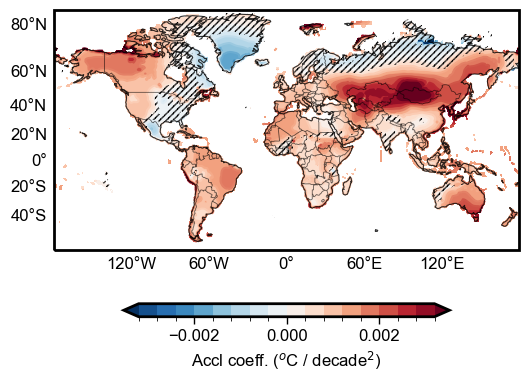

In [17]:
plt.figure(figsize=(6,7))
ax = plt.axes(projection=ccrs.Miller())
lvls = np.arange(-0.0032, 0.0036, 0.0004)
ax.set_extent([-180, 180, -60, 85])
# best100.acccl.plot(cmap='RdBu_r', vmin=-0.0032, extend='both', transform=ccrs.PlateCarree(), cbar_kwargs=dict(orientation='horizontal', shrink=0.7, pad=0.10, label = 'Accl coeff. ($^{o}$C / decade$^{2}$)'))
best100_land.acccl.plot.contourf(cmap='RdBu_r', levels=lvls, extend='both', transform=ccrs.PlateCarree(), \
                            cbar_kwargs=dict(orientation='horizontal', shrink=0.7, aspect=25, pad=0.10, label = 'Accl coeff. ($^{o}$C / decade$^{2}$)', ticks=[-0.002, 0, 0.002]))
best100_land.acccl.plot.contour(cmap='RdBu_r', levels=lvls, extend='both', transform=ccrs.PlateCarree())
z = np.ma.masked_less(best100_land.pval, 0.05)
plt.pcolor(x, y, z, hatch='/////', alpha=0., lw=0.5, transform=ccrs.PlateCarree(), zorder=2)
# plt.scatter(x[pval100_land < 0.6], y[pval100_land < 0.6], marker='.', transform=ccrs.PlateCarree(), s=1, color='k')
ax.add_feature(cfeature.COASTLINE, lw=0.8, alpha=0.8, zorder=2)
# ax.add_feature(cfeature.OCEAN, color='white', zorde1=2)
ax.add_feature(cfeature.BORDERS, lw=0.6, alpha=0.6, zorder=3)
gl = ax.gridlines(draw_labels=True, alpha=0.)
gl.top_labels = False
gl.right_labels = False
ax.set_title('')
plt.savefig('./images/accl/best100_land.png', dpi=300, bbox_inches = 'tight')

In [11]:
# plotting code
import matplotlib as m
from matplotlib import hatch
from matplotlib.colors import BoundaryNorm as BM
from matplotlib.colors import Normalize as NN


def plot_background(ax):
    ax.set_extent([-180, 180, -60, 85])
    # ax.add_feature(cfeature.LAND, color='lightgray')
    # ax.add_feature(cfeature.OCEAN, color='lightgray')
    ax.add_feature(cfeature.COASTLINE, lw=0.8, alpha=0.8, zorder=2)
    ax.add_feature(cfeature.BORDERS, lw=0.6, alpha=0.6, zorder=2)
    gl = ax.gridlines(draw_labels=False,
                      linewidth=1, color='gray', alpha=0.01, linestyle='--')
    gl.top_labels = False
    # gl.left_labels = False
    # gl.bottom_labels = False
    gl.right_labels = False
    gl.xlines = False
    # gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    return ax


def plot_mesh(x, y, xl1, yl1, xl2, yl2, z, titles, lvls, tick_ns, cmap, extend='both', cbar_label = "Accl coeff. ($^{o}$C / decade$^{2}$)", pval = [], sign_val=0.05, nrows=1, ncols=3, figsize=(12,4), ocean_mask_list = [], central_longitude=0):
    fig, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True, subplot_kw={'projection':ccrs.Miller(central_longitude=central_longitude)})
    
    axlist = axarr.flatten()
    
    for ax in axlist:
        plot_background(ax)
    
    for i in range(len(z)):
        if i in [0, 4, 8, 12, 16]:
            axlist[i].contourf(x, y, z[i], cmap = cmap, levels=lvls, transform = ccrs.PlateCarree(central_longitude=0), extend=extend)
            if pval != []:
                insig =  np.ma.masked_less(pval[i], sign_val)
                # axlist[i].scatter(x[np.abs(pval[i]) < sign_val], y[np.abs(pval1[i]) < sign_val], color = 'k', s = 0.1, marker='o', alpha = 0.8, transform = ccrs.PlateCarree(central_longitude=0))
                axlist[i].pcolor(x, y, insig, hatch='/////', alpha=0., lw=0.5, transform=ccrs.PlateCarree(), zorder=1)
        elif i in [1, 5, 9, 13, 17]:
            axlist[i].contourf(xl1, yl1, z[i], cmap = cmap, levels=lvls, transform = ccrs.PlateCarree(central_longitude=0), extend=extend)
            if pval != []:
                insig =  np.ma.masked_less(pval[i], sign_val)
                # axlist[i].scatter(x[np.abs(pval[i]) < sign_val], y[np.abs(pval1[i]) < sign_val], color = 'k', s = 0.1, marker='o', alpha = 0.8, transform = ccrs.PlateCarree(central_longitude=0))
                axlist[i].pcolor(xl1, yl1, insig, hatch='/////', alpha=0., lw=0.5, transform=ccrs.PlateCarree(), zorder=1)
        else:
            axlist[i].contourf(xl2, yl2, z[i], cmap = cmap, levels=lvls, transform = ccrs.PlateCarree(central_longitude=0), extend=extend)
            if pval != []:
                insig =  np.ma.masked_less(pval[i], sign_val)
                # axlist[i].scatter(x[np.abs(pval[i]) < sign_val], y[np.abs(pval1[i]) < sign_val], color = 'k', s = 0.1, marker='o', alpha = 0.8, transform = ccrs.PlateCarree(central_longitude=0))
                axlist[i].pcolor(xl2, yl2, insig, hatch='/////', alpha=0., lw=0.5, transform=ccrs.PlateCarree(), zorder=1)
        axlist[i].set_title(titles[i])
        if i in ocean_mask_list:
            axlist[i].add_feature(cfeature.OCEAN, color = 'white', zorder=1)
            # axlist[i].set_title('IMD', fontdict={'fontsize':12})
        
    norm = BM(lvls, 256)
    cbar = fig.colorbar(m.cm.ScalarMappable(norm = norm, cmap=cmap), ax = axlist, extend=extend, \
                orientation = 'vertical', shrink=0.4, aspect = 20, pad = 0.02, label = cbar_label, ticks=tick_ns)

In [16]:
plot_list = [best100.acccl, best5deg100.acccl]
pval_list = [best100.pval, best5deg100.pval]
titles = ['Berkeley Earth (100y) 1deg', 'Berkeley Earth (100y) 5deg']
lvls = np.arange(-0.0032, 0.0036, 0.0004)

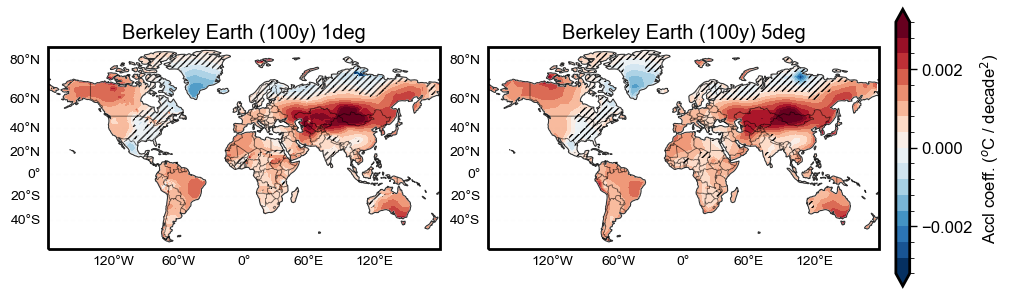

In [36]:
plot_mesh(x, y, xl2, yl2, xl2, yl2, plot_list, titles, lvls=lvls, tick_ns=[-0.002, 0, 0.002], cmap='RdBu_r', pval=pval_list, sign_val=0.05, nrows=1, ncols=2, figsize=(10, 7), ocean_mask_list=[0, 1])
plt.savefig('./images/accl/resolution_comparison.png', dpi=300, bbox_inches='tight')

In [21]:
plot_list = [best100.acccl, gistemp100.acccl, hadcrut5deg100.acccl,  noaa5deg100.acccl.isel(z=0),
             best70.acccl, gistemp70.acccl, hadcrut5deg70.acccl,  noaa5deg70.acccl.isel(z=0),
             best50.acccl, gistemp50.acccl, hadcrut5deg50.acccl,  noaa5deg50.acccl.isel(z=0),
             best30.acccl, gistemp30.acccl, hadcrut5deg30.acccl,  noaa5deg30.acccl.isel(z=0)]

pval_list = [best100.pval, gistemp100.pval, hadcrut5deg100.pval,  noaa5deg100.pval.isel(z=0),
             best70.pval, gistemp70.pval, hadcrut5deg70.pval,  noaa5deg70.pval.isel(z=0),
             best50.pval, gistemp50.pval, hadcrut5deg50.pval,  noaa5deg50.pval.isel(z=0),
             best30.pval, gistemp30.pval, hadcrut5deg30.pval,  noaa5deg30.pval.isel(z=0)]

titles = [r'Berkeley Earth (100y) $1^o \times 1^o$', r'GISTEMP (100y) $2^o \times 2^o$', r'HADCRUT5 (100y) $5^o \times 5^o$', r'NOAAGlobalTemp (100y) $5^o \times 5^o$',
          r'Berkeley Earth (70y) $1^o \times 1^o$', r'GISTEMP (70y) $2^o \times 2^o$', r'HADCRUT5 (70y) $5^o \times 5^o$', r'NOAAGlobalTemp (70y) $5^o \times 5^o$',
          r'Berkeley Earth (50y) $1^o \times 1^o$', r'GISTEMP (50y) $2^o \times 2^o$', r'HADCRUT5 (50y) $5^o \times 5^o$', r'NOAAGlobalTemp (50y) $5^o \times 5^o$',
          r'Berkeley Earth (30y) $1^o \times 1^o$', r'GISTEMP (30y) $2^o \times 2^o$', r'HADCRUT5 (30y) $5^o \times 5^o$', r'NOAAGlobalTemp (30y) $5^o \times 5^o$']

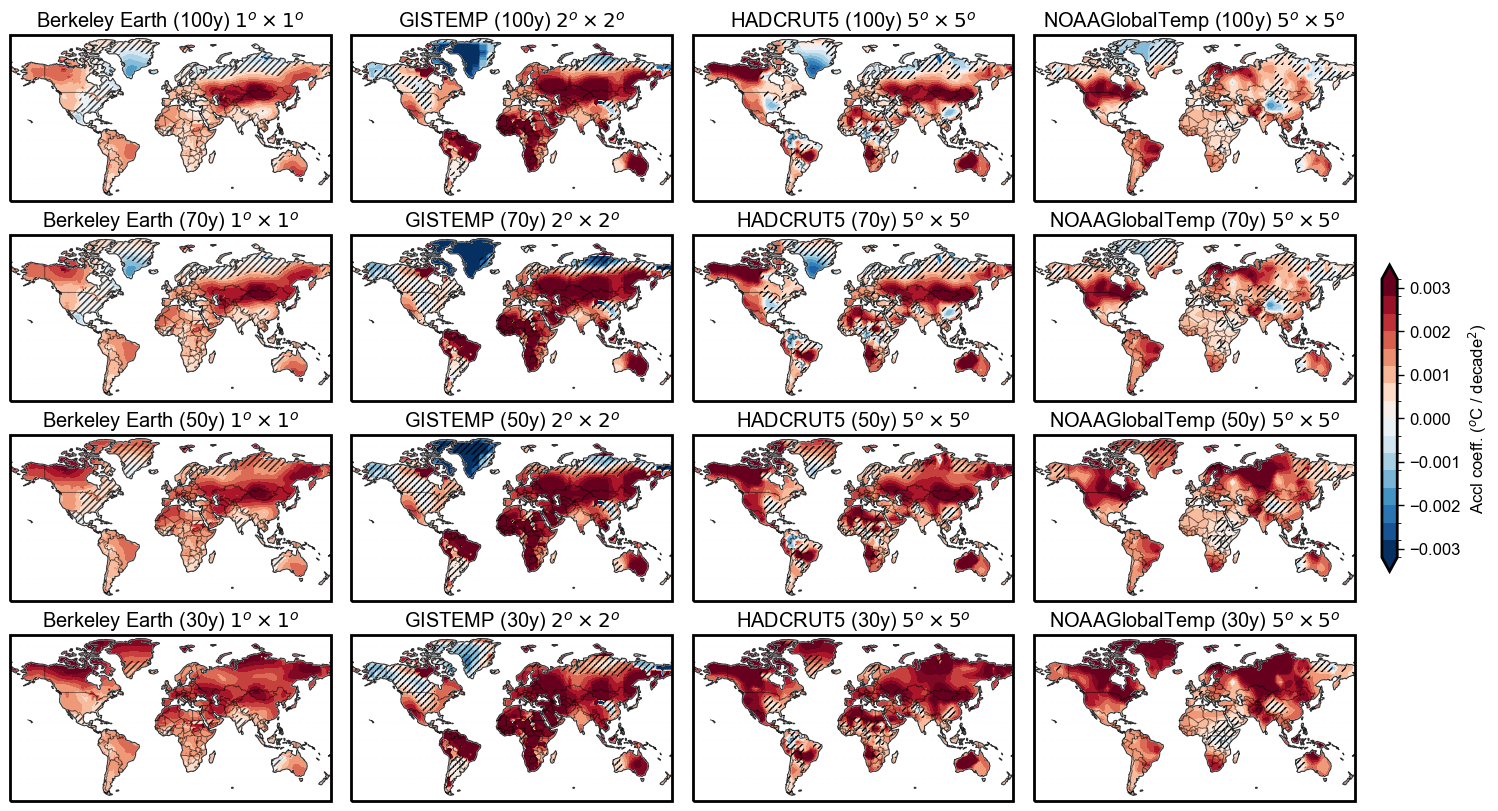

In [22]:
plot_mesh(x, y, xl1, yl1, xl2, yl2, plot_list, titles, lvls=lvls, tick_ns=[-0.003, -0.002, -0.001, 0, 0.001, 0.002, 0.003], cmap='RdBu_r', pval=pval_list, sign_val=0.05, nrows=4, ncols=4, figsize=(15, 8), ocean_mask_list=np.arange(0, 20, 1))
plt.savefig('./images/accl/dataset_window_comparison', dpi=300, bbox_inches='tight')

### testing the datasets

In [13]:
best = xc.open_dataset('./data/tas/Berkeley_Earth_Land_and_Ocean_LatLong1.nc', lon_orient=(-180, 180))
best['time'] = pd.date_range(start='1850-01-01', end='2023-09-01', freq='1M')
best = best.rename(dict(latitude='lat', longitude='lon'))
hadcrut = xc.open_dataset('./data/tas/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc', lon_orient=(-180, 180))
hadcrut = hadcrut.rename(dict(latitude='lat', longitude='lon'))
noaa = xc.open_dataset('./data/tas/NOAAGlobalTemp_v5.1.0_gridded_s185001_e202308_c20230908T112802.nc', lon_orient=(-180, 180))
gistemp = xc.open_dataset('./data/tas/GISTEMP_v4_air.2x2.250.mon.anom.comb.nc', lon_orient=(-180, 180))

2024-01-11 19:28:35,099 [WARNING]: dataset.py(_is_decodable:595) >> The 'units' attribute (year A.D.) for 'time' is not in the supported format 'X since Y', so it could not be decoded.


2024-01-11 19:28:35,293 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


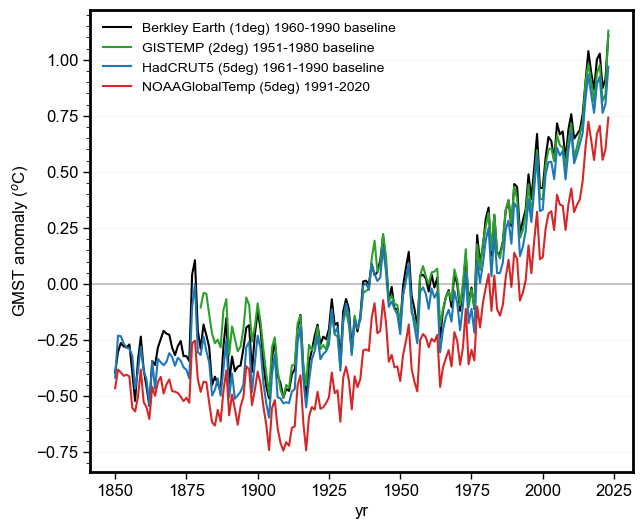

In [162]:
plt.figure(figsize=(7,6))
preprocess_temp.calc_gmst(best.temperature).plot(label = 'Berkley Earth (1deg) 1960-1990 baseline', color='k')
preprocess_temp.calc_gmst(gistemp.air).plot(label = 'GISTEMP (2deg) 1951-1980 baseline', color='tab:green')
preprocess_temp.calc_gmst(hadcrut.tas_mean).plot(label = 'HadCRUT5 (5deg) 1961-1990 baseline', color='tab:blue')
preprocess_temp.calc_gmst(noaa.anom).plot(label = 'NOAAGlobalTemp (5deg) 1991-2020', color='tab:red')
plt.minorticks_on()
plt.gca().tick_params(which='minor', axis='x', bottom=False)
plt.title('')
plt.ylabel('GMST anomaly ($^{o}$C)')
plt.xlabel('yr')
plt.grid(axis='y', alpha=0.1)
plt.axhline(0.0, lw=0.3, ls='-', color='k')
plt.legend(fontsize=10, frameon=False)
plt.savefig('./images/gmst_ts.png', dpi=300, bbox_inches='tight')

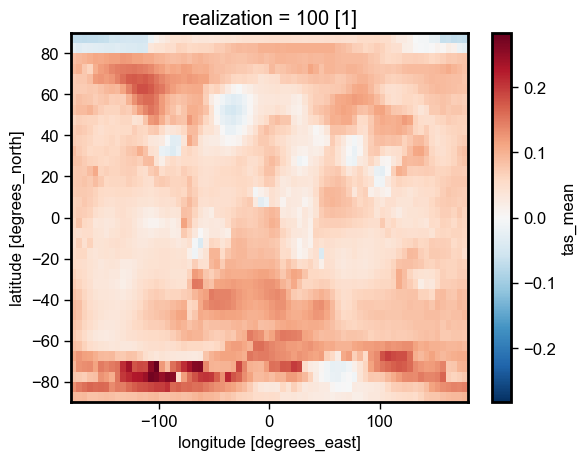

In [18]:
trend_analysis.calc_trend3d(hadcrut.groupby('time.year').mean('time').sel(year = slice(1890, 1990)), dim='year').tas_mean.plot()

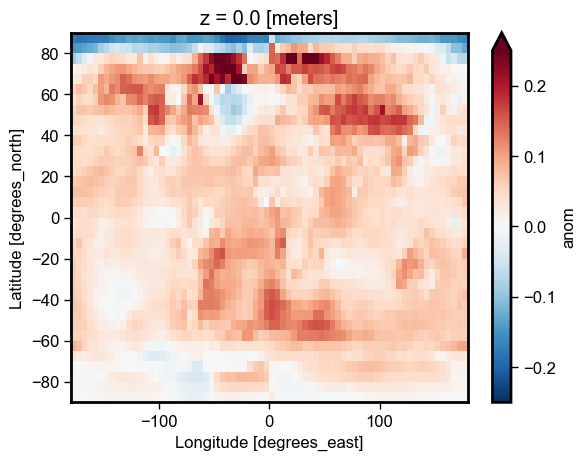

In [19]:
trend_analysis.calc_trend3d(noaa.groupby('time.year').mean('time').sel(year = slice(1890, 1990)), dim='year').anom.plot(vmin=-0.25)

In [20]:
test  = trend_analysis.calc_trend3d(gistemp.air.groupby('time.year').mean('time').sel(year = slice(1890, 1990)), dim='year')

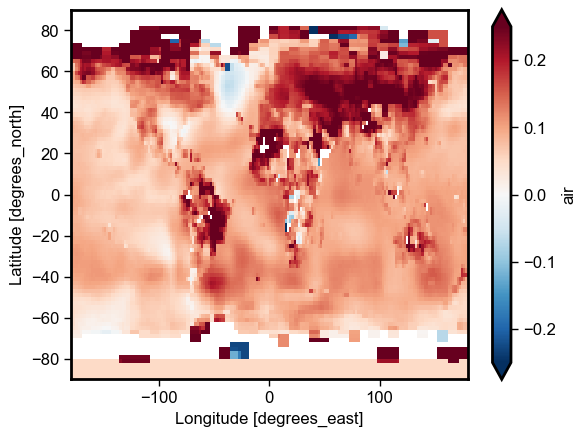

In [17]:
test.plot.pcolormesh(vmin=-0.25)

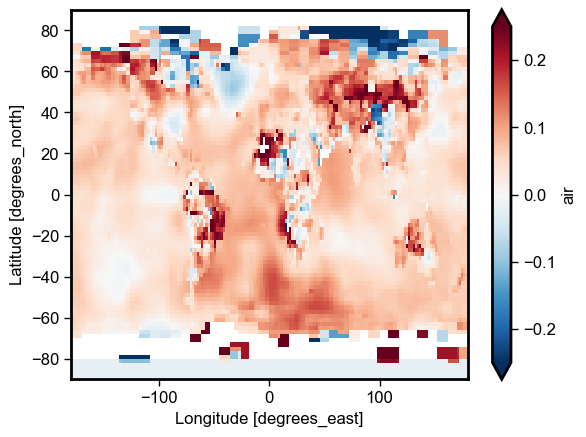

In [21]:
test.plot.pcolormesh(vmin=-0.25)